In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import gymnasium as gym
import gymnasium.spaces as spaces
from gymnasium.utils.save_video import save_video

import numpy as np
from PIL import Image, ImageDraw, ImageFont

import torchvision
import torchvision.io as vio
import torchvision.transforms as transforms

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.nn import GCNConv, Node2Vec
import torch_scatter

import gc
import os
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation

from IPython.core.display import HTML

from tqdm import tqdm
from pathlib import Path
from itertools import count
from dataclasses import dataclass

import hydra
import string
from omegaconf import DictConfig, OmegaConf
from functools import lru_cache
from gensim.models import FastText


__file__ = str(Path("main.ipynb").resolve())
root = Path(__file__).parent
print(torch.cuda.is_available())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [3]:
@lru_cache(maxsize=4096)
def levenshtein_distance(s, t):
    """文字列のレーベンシュタイン距離を計算する"""
    # 一方が空文字列なら、他方の長さが求める距離
    if not s:
        return len(t)
    if not t:
        return len(s)

    # 一文字目が一致なら、二文字目以降の距離が求める距離
    if s[0] == t[0]:
        return levenshtein_distance(s[1:], t[1:])

    # 一文字目が不一致なら、追加／削除／置換のそれぞれを実施し、
    # 残りの文字列についてのコストを計算する
    l1 = levenshtein_distance(s, t[1:])
    l2 = levenshtein_distance(s[1:], t)
    l3 = levenshtein_distance(s[1:], t[1:])

    # 追加／削除／置換を実施した分コスト（距離）1の消費は確定
    # 残りの文字列についてのコストの最小値を足せば距離となる
    return 1 + min(l1, l2, l3)


def tuplize(x):
    if isinstance(x, int):
        return (x, x)
    else:
        return x


def to_tensor(x, dtype=torch.float32, device=DEVICE):
    if isinstance(x, list) and len(x) > 0 and not isinstance(x[0], torch.Tensor):
        x = np.array(x)
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=dtype)
    return x.to(device)


def get_flat_params(module: nn.Module):
    return torch.cat([param.view(-1) for param in module.parameters()])


def set_params(module: nn.Module, new_flat_params):
    start_idx = 0
    for param in module.parameters():
        end_idx = int(start_idx + np.prod(list(param.shape)))
        param.data = torch.reshape(new_flat_params[start_idx:end_idx], param.shape)
        start_idx = end_idx


def get_flat_grads(f, net):
    flat_grads = torch.cat(
        [
            grad.view(-1)
            for grad in torch.autograd.grad(f, net.parameters(), create_graph=True)
        ]
    )
    return flat_grads


def conjugate_gradient(Av_func, b, max_iter=10, residual_tol=1e-10):
    x = torch.zeros_like(b)
    r = b - Av_func(x)
    p = r
    rsold = r.norm() ** 2

    for _ in range(max_iter):
        Ap = Av_func(p)
        alpha = rsold / torch.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = r.norm() ** 2
        if torch.sqrt(rsnew) < residual_tol:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x


def rescale_and_linesearch(
    g, s, Hs, max_kl, L, kld, old_params, pi, max_iter=10, success_ratio=0.1
):
    set_params(pi, old_params)
    L_old = L().detach()

    beta = torch.sqrt((2 * max_kl) / torch.dot(s, Hs))

    for _ in range(max_iter):
        new_params = old_params + beta * s

        set_params(pi, new_params)
        kld_new = kld().detach()

        L_new = L().detach()

        actual_improv = L_new - L_old
        approx_improv = torch.dot(g, beta * s)
        ratio = actual_improv / approx_improv

        if ratio > success_ratio and actual_improv > 0 and kld_new < max_kl:
            return new_params

        beta *= 0.5

    print("The line search was failed!")
    return old_params


class Image2Graph:
    def __init__(
        self,
        kernel_size=3,
        dilation=1,
        stride=0,
        padding=0,
        k=5,
        feature_dist_weight=1.0,
        euclid_dist_weight=0.1,
    ):
        if stride == 0:
            stride = kernel_size
        self.kernel_size = tuplize(kernel_size)
        self.dilation = tuplize(dilation)
        self.stride = tuplize(stride)
        self.padding = tuplize(padding)
        self.k = k
        self.feature_dist_weight = feature_dist_weight
        self.euclid_dist_weight = euclid_dist_weight

    def __call__(self, image: torch.Tensor):
        channel, height, width = image.shape
        image_patches = (
            image.unfold(1, self.kernel_size[0], self.stride[0])
            .unfold(2, self.kernel_size[1], self.stride[1])
            .reshape(channel, -1, self.kernel_size[0], self.kernel_size[1])
            .permute(1, 0, 2, 3)
        )
        edges_link = []
        edges_attr = []
        dx = width // self.kernel_size[0]
        distance_matrix = torch.zeros(image_patches.shape[0], image_patches.shape[0])
        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[0]):
                if i == j:
                    continue
                distance_matrix[i, j] = (
                    torch.dist(image_patches[i], image_patches[j])
                    / (self.kernel_size[0] * self.kernel_size[1])
                    + (((i // dx - j // dx) ** 2 + (i % dx - j % dx) ** 2) ** 0.5 / dx)
                    * self.euclid_dist_weight
                )

            topk = torch.topk(distance_matrix[i], self.k + 1, largest=False)
            for indice in topk.indices[1:]:
                edges_link.append((i, indice))
                edges_attr.append(distance_matrix[i, indice])

        edges_attr = torch.tensor(edges_attr)
        edges_link = torch.tensor(edges_link).t().contiguous()

        return image_patches, edges_link, edges_attr

In [4]:
data_dir = root / "data"
chars_dir = data_dir / "chars"

transform = transforms.Compose([transforms.ToTensor(), Image2Graph()])
load_datasets = {
    "MNIST": lambda is_train=True: torchvision.datasets.MNIST(
        root=str(data_dir), train=is_train, download=True, transform=transform
    ),
    "CIFAR-10": lambda is_train=True: torchvision.datasets.CIFAR10(
        root=str(data_dir), train=is_train, download=True, transform=transform
    ),
    "CIFAR-100": lambda is_train=True: torchvision.datasets.CIFAR100(
        root=str(data_dir), train=is_train, download=True, transform=transform
    ),
}


target = "CIFAR-100"
train_dataset = load_datasets[target](is_train=True)
test_dataset = load_datasets[target](is_train=False)
print(max(map(len, train_dataset.classes)))
print(train_dataset.classes)

Files already downloaded and verified
Files already downloaded and verified
13
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tra

In [5]:
def word2chars(word):
    if len(word) == 1:
        return word
    else:
        return word2chars(word[:-1]) + " " + word[:-1]


class_chars = []
for class_name in train_dataset.classes:
    chars = word2chars(class_name).split(" ")[1:]
    chars.append(class_name)
    class_chars.append(chars)
print(class_chars[0])
# char2vec_model = FastText(class_chars, vector_size=16, window=4, min_count=1, workers=4)
# char2vec_model.train(class_chars, total_examples=len(class_chars), epochs=1000)

# char2vec = char2vec_model.wv

['a', 'ap', 'app', 'appl', 'apple']


In [6]:
# char2vec_model.wv[""]

In [7]:
%%time

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for (image_patches, edges_link, edges_attr), label in train_dataloader:
    image_patches, edges_link, edges_attr = image_patches[0], edges_link[0], edges_attr[0]
    print(image_patches.shape, image_patches.min(), image_patches.max())
    print(edges_link.shape)
    print(edges_attr.shape, edges_attr.min(), edges_attr.max())
    x = GCNConv(27, 64)(image_patches.reshape(100, -1), edges_link, edges_attr)
    x = nn.ReLU()(x)
    x = GCNConv(64, 128)(x, edges_link, edges_attr)
    x = nn.ReLU()(x)
    x, _ = torch_scatter.scatter_max(x, torch.arange(100), dim=0)
    x = nn.Linear(128, 100)(x)
    x = nn.ReLU()(x)
    x = nn.Linear(100, 1)(x)
    x = image_patches * x.reshape(100, 1, 1, 1)
    print(x.shape)
    break

torch.Size([100, 3, 3, 3]) tensor(0.0549) tensor(0.9137)
torch.Size([2, 500])
torch.Size([500]) tensor(0.0138) tensor(0.1818)
torch.Size([100, 3, 3, 3])
CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 255 ms


In [8]:
VALID_CHARS = string.ascii_lowercase + "_"
print(VALID_CHARS)
char_embedding_size = 4

abcdefghijklmnopqrstuvwxyz_


In [20]:
"""
行動空間
- テキスト出力

観測空間
- 出力したテキスト + 画像グラフ
"""


class GraphEncoder(nn.Module):
    def __init__(
        self, node_num=100, node_feature_size=27, embedding_size=128, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.node_num = node_num
        self.gcn1 = GCNConv(node_feature_size, 64)
        self.gcn2 = GCNConv(64, 128)
        self.gcn3 = GCNConv(128, 256)
        self.bc = nn.BatchNorm1d(256)
        self.linear1 = nn.Linear(256, 10)
        self.linear2 = nn.Linear(1000, embedding_size)

    def forward(self, data: Data):
        x, edges_link, edges_attr = data.x[0], data.edge_index[0], data.edge_attr[0]
        x = self.gcn1(x.reshape(self.node_num, -1), edges_link, edges_attr)
        x = F.relu(x)
        x = self.gcn2(x, edges_link, edges_attr)
        x = F.relu(x)
        x = self.gcn3(x, edges_link, edges_attr)
        x = F.relu(x)
        x = self.bc(x)
        x, _ = torch_scatter.scatter_max(x, torch.arange(self.node_num), dim=0)
        x = self.linear1(x).flatten()
        x = F.relu(x)
        x = self.linear2(x)
        return x


class PolicyNetworkBase(nn.Module):
    # 現状から次の行動を決定する
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = nn.Sequential(
            nn.Linear(self.state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, self.action_dim),
        )

    def get_distribution(self, states) -> torch.distributions.distribution.Distribution:
        raise NotImplementedError()

    def forward(
        self, states
    ) -> torch.distributions.distribution.Distribution:  # 状態をもとにアクションを決定
        states = to_tensor(states)
        return self.get_distribution(states)


class DiscreatePolicyNetwork(PolicyNetworkBase):
    # 離散的な行動をとる
    def get_distribution(self, states):
        probs = torch.softmax(self.net(states), dim=-1)
        return torch.distributions.Categorical(probs)


class ValueNetwork(nn.Module):
    # 状態から価値を予測する
    def __init__(self, state_dim, hidden_dim=32):
        super().__init__()
        self.state_dim = state_dim
        self.net = nn.Sequential(
            nn.Linear(self.state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, states):
        states = to_tensor(states)
        return self.net(states)


class DiscreteDiscriminator(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super().__init__()
        self.action_emb = nn.Embedding(action_dim, state_dim)

        self.net = nn.Sequential(
            nn.Linear(state_dim + state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
        )

    def get_logits(self, states, actions):
        states = to_tensor(states)
        actions = to_tensor(actions)
        actions = self.action_emb(actions.long())
        x = torch.cat([states, actions], dim=-1)
        return self.net(x)

    def forward(self, states, actions):
        return torch.sigmoid(self.get_logits(states, actions))


class Expert(nn.Module):
    def __init__(self):
        super().__init__()

    def get_action(self, states):
        return VALID_CHARS.index(states["true"][len(states["text"])])


class ImageTextEnv(gym.Env):
    def __init__(self, graphloader: DataLoader, image_embedding_size=128):
        super().__init__()
        self.iterloader = iter(graphloader)
        self.text = ""
        self.image_graph = Data()
        self.image_graph_encoder = GraphEncoder(embedding_size=image_embedding_size)

        self.action_space = spaces.Discrete(len(VALID_CHARS) + 1)
        self.observation_space = spaces.Dict(
            {
                "text": spaces.Text(16),
                "true": spaces.Text(16),
                "emb": spaces.Box(low=0, high=1, shape=(image_embedding_size,)),
            }
        )
        self.reset()

    def get_next_graph(self):
        return next(self.iterloader)

    def reset(self):
        self.text = ""
        (image_patches, edges_link, edges_attr), label = self.get_next_graph()

        self.image_graph = Data(
            x=image_patches,
            edge_index=edges_link,
            edge_attr=edges_attr,
            y=train_dataset.classes[label],
        )
        return {
            "text": self.text,
            "true": self.image_graph.y,
            "emb": self.image_graph_encoder(self.image_graph).to(DEVICE),
        }, {}

    def step(self, action_index):
        info = {}
        terminated, truncated = False, False
        if action_index == len(VALID_CHARS):  # EOS
            truncated = True
        else:
            self.text += VALID_CHARS[action_index]
        if len(self.text) >= len(self.image_graph.y):
            truncated = True

        reward = -levenshtein_distance(self.text, self.image_graph.y)
        if self.text == self.image_graph.y:
            terminated = True
        observation = {
            "text": self.text,
            "true": self.image_graph.y,
            "emb": self.image_graph_encoder(self.image_graph).to(DEVICE),
        }
        return observation, reward, terminated, truncated, info


class Chars2Vec(nn.Module):
    def __init__(self, char_vec_dim=32, device=DEVICE):
        super().__init__()
        self.fast_text = FastText(
            class_chars, vector_size=char_vec_dim, window=8, min_count=1, workers=4
        )
        self.fast_text.train(class_chars, total_examples=len(class_chars), epochs=1000)
        self.device = device

    def forward(self, chars):
        return torch.from_numpy(self.fast_text.wv[chars].copy()).to(self.device)


class GAIL(nn.Module):
    def __init__(
        self,
        state_dim=128,
        action_dim=len(VALID_CHARS),
        char_vec_dim=32,
        policy_hidden_dim=32,
        value_hidden_dim=32,
    ):
        super().__init__()
        self.state_dim = state_dim + char_vec_dim
        self.action_dim = action_dim

        self.policy_net = DiscreatePolicyNetwork(
            self.state_dim, self.action_dim, hidden_dim=policy_hidden_dim
        )
        self.value_net = ValueNetwork(self.state_dim, hidden_dim=value_hidden_dim)
        self.discriminator = DiscreteDiscriminator(
            self.state_dim, self.action_dim, hidden_dim=value_hidden_dim
        )
        self.char_emb = Chars2Vec()

    def get_text_emb(self, text):
        return self.char_emb(text)

    def get_action(self, states):
        with torch.inference_mode():
            dist = self.policy_net(torch.cat([states["emb"], self.get_text_emb(states["text"])]))  # type: ignore
        return dist.sample().detach().cpu().numpy()

    def train(self, env: ImageTextEnv, agent: Expert):
        num_steps_per_epochs = 100
        num_epochs = 10
        gae_gamma = 0.99
        gae_lambda = 0.99
        max_kl = 0.01
        epsilon = 0.01
        normarize_advantage = True
        lambda_ = 0.001
        cg_damping = 0.1

        agent_observations = []
        agent_actions = []
        agent_rewards = []
        max_reward = -np.inf
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters())

        step = 0
        while step < num_steps_per_epochs:
            observation, _ = env.reset()
            agent_rewards_step = []
            agent_observations_step = []
            terminated, truncated = False, False
            reward = -np.inf

            while (
                (not terminated) and (not truncated) and (step < num_steps_per_epochs)
            ):
                action = agent.get_action(observation)
                obs = torch.cat(
                    [observation["emb"], self.get_text_emb(observation["text"])]
                )
                agent_observations_step.append(obs)
                agent_observations.append(obs)
                agent_actions.append(action)

                observation, reward, terminated, truncated, info = env.step(action)
                agent_rewards_step.append(reward)

                step += 1

            # print(f"step: {step}, label: {observation['true']}, text: {observation['text']}, reward: {reward}")

            agent_rewards.append(torch.sum(to_tensor(agent_rewards_step)))
            agent_observations_step = torch.vstack(agent_observations_step)
            agent_rewards_step = to_tensor(agent_rewards_step)

        agent_rewards_mean = to_tensor(agent_rewards).mean()
        max_reward = max(max_reward, agent_rewards_mean.item())
        print(f"agent_rewards_mean: {agent_rewards_mean}")

        agent_observations = torch.vstack(agent_observations)
        agent_actions = to_tensor(agent_actions, dtype=torch.long)
        reward_epoch_means = []

        for i in range(num_epochs):
            rewards_epochs = []
            observations_epochs = []
            actions_epochs = []
            returns_epochs = []
            advantages_epochs = []
            gae_gammas_epochs = []

            steps = 0
            while steps < num_steps_per_epochs:
                rewards_step = []
                observations_step = []
                actions_step = []
                gae_gammas_step = []
                lambdas_step = []
                t = 0
                terminated, truncated = False, False

                observation, _ = env.reset()

                while (
                    (not terminated)
                    and (not truncated)
                    and (steps < num_steps_per_epochs)
                ):
                    action = self.get_action(observation)
                    observation, reward, terminated, truncated, info = env.step(action)

                    obs = torch.cat(
                        [observation["emb"], self.get_text_emb(observation["text"])]
                    )
                    observations_step.append(obs)
                    observations_epochs.append(obs)

                    actions_step.append(action)
                    actions_epochs.append(action)

                    rewards_step.append(reward)
                    gae_gammas_step.append(gae_gamma**t)
                    lambdas_step.append(gae_lambda**t)

                    t += 1
                    steps += 1

                # print(f"step: {steps}, observation_text: {observation['text']}, label: {observation['true']}")
                rewards_epochs.append(torch.sum(to_tensor(rewards_step)))
                rewards_step = to_tensor(rewards_step)
                observations_step = torch.vstack(observations_step)
                actions_step = to_tensor(actions_step, dtype=torch.long)
                gae_gammas_step = to_tensor(gae_gammas_step)
                lambdas_step = to_tensor(lambdas_step)
                costs_step = (
                    -torch.log(self.discriminator(observations_step, actions_step))
                    .squeeze()
                    .detach()
                )

                discriminator_costs_step = gae_gammas_step * costs_step
                discriminator_returns_step = to_tensor(
                    [discriminator_costs_step[i:].sum() for i in range(t)]
                )
                returns_step = discriminator_returns_step / gae_gammas_step
                returns_epochs.append(returns_step)

                self.value_net.eval()
                current_values = self.value_net(observations_step).detach()
                next_values = torch.cat(
                    (self.value_net(observations_step)[1:], to_tensor([[0.0]]))
                ).detach()
                deltas_step = (
                    costs_step.unsqueeze(-1) + gae_gamma * next_values - current_values
                )
                advantages_step = to_tensor(
                    [
                        (
                            (gae_gammas_step * lambdas_step)[: t - j].unsqueeze(-1)
                            * deltas_step[j:]
                        ).sum()
                        for j in range(t)
                    ]
                )
                advantages_epochs.append(advantages_step)
                gae_gammas_epochs.append(gae_gammas_step)

            reward_epoch_means.append(to_tensor(rewards_epochs).mean())

            observations_epochs = torch.vstack(observations_epochs)
            actions_epochs = to_tensor(actions_epochs, dtype=torch.long)
            returns_epochs = torch.cat(returns_epochs)
            advantages_epochs = torch.cat(advantages_epochs)
            gae_gammas_epochs = torch.cat(gae_gammas_epochs)

            if normarize_advantage:
                advantages_epochs = (
                    advantages_epochs - advantages_epochs.mean()
                ) / advantages_epochs.std()

            self.discriminator.train()
            novelty_scores = self.discriminator.get_logits(
                observations_epochs, actions_epochs
            )
            agent_scores = self.discriminator.get_logits(
                agent_observations, agent_actions
            )

            self.discriminator_optimizer.zero_grad()
            loss = (
                torch.nn.functional.binary_cross_entropy_with_logits(
                    agent_scores, torch.zeros_like(agent_scores)
                )
                + torch.nn.functional.binary_cross_entropy_with_logits(
                    novelty_scores, torch.ones_like(novelty_scores)
                )
                # + agent_rewards_mean / (reward_epoch_means[-1] + 1)
            )
            loss.backward(retain_graph=True)
            self.discriminator_optimizer.step()

            print(
                f"Epoch {i + 1},  Reward Mean: {reward_epoch_means[-1]}, Loss: {loss.item():.4f}"
            )

            if reward_epoch_means[-1] > max_reward:
                print(f"- Saving model with reward {reward_epoch_means[-1]}")
                torch.save(
                    self.policy_net.state_dict(),
                    Path(__file__).parent / "policy_net.pt",
                )
                max_reward = reward_epoch_means[-1]

            self.value_net.train()
            pred_values_params = get_flat_params(self.value_net).detach()
            prev_values_epochs = self.value_net(observations_epochs).detach()
            grad_diffs = get_flat_grads(
                (prev_values_epochs - self.value_net(observations_epochs))
                .pow(2)
                .mean(),
                self.value_net,
            )
            g = get_flat_grads(
                (
                    (-1)
                    * (
                        self.value_net(observations_epochs).squeeze() - returns_epochs
                    ).pow(2)
                ).mean(),
                self.value_net,
            )

            def Hv(v):
                return get_flat_grads(torch.dot(grad_diffs, v), self.value_net).detach()

            s = conjugate_gradient(Hv, g)
            Hs = Hv(s)
            alpha = torch.sqrt(2 * epsilon / torch.dot(s, Hs))

            new_params = pred_values_params + alpha * s
            set_params(self.value_net, new_params)

            self.policy_net.train()
            prev_policy_params = get_flat_params(self.policy_net).detach()
            prev_distribution = self.policy_net(observations_epochs)

            def L():
                distb = self.policy_net(observations_epochs)
                return (
                    advantages_epochs
                    * torch.exp(
                        distb.log_prob(actions_epochs)
                        - prev_distribution.log_prob(actions_epochs).detach()
                    )
                ).mean()

            def kld():
                distb = self.policy_net(observations_epochs)
                old_probs = prev_distribution.probs.detach()
                probs = distb.probs
                return (
                    (old_probs * (torch.log(old_probs) - torch.log(probs)))
                    .sum(-1)
                    .mean()
                )

            grad_kld_old_param = get_flat_grads(kld(), self.policy_net)

            def Hv(v):
                return (
                    get_flat_grads(
                        torch.dot(grad_kld_old_param, v), self.policy_net
                    ).detach()
                    + cg_damping * v
                )

            g = get_flat_grads(L(), self.policy_net).detach()
            s = conjugate_gradient(Hv, g)
            Hs = Hv(s).detach()

            new_params = rescale_and_linesearch(
                g,
                s,
                Hs,
                max_kl,
                L,
                kld,
                prev_policy_params,
                self.policy_net,
            )

            disc_causal_entropy = (
                (-1)
                * gae_gammas_epochs
                * self.policy_net(observations_epochs).log_prob(actions_epochs)
            ).mean()

            grad_disc_causal_entropy = get_flat_grads(
                disc_causal_entropy, self.policy_net
            )
            new_params += lambda_ * grad_disc_causal_entropy

            set_params(self.policy_net, new_params)
        return agent_rewards_mean, reward_epoch_means


train_dataloader = DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)
env = ImageTextEnv(train_dataloader)
agent = Expert()
gail = GAIL()
agent.to(DEVICE)
gail.to(DEVICE)
gail.train(env, agent)

agent_rewards_mean: -15.833333015441895
Epoch 1,  Reward Mean: -38.35293960571289, Loss: 1.3792
Epoch 2,  Reward Mean: -29.842105865478516, Loss: 1.3626
Epoch 3,  Reward Mean: -47.400001525878906, Loss: 1.3243
Epoch 4,  Reward Mean: -40.411766052246094, Loss: 1.2962
Epoch 5,  Reward Mean: -38.64706039428711, Loss: 1.2918
Epoch 6,  Reward Mean: -34.61111068725586, Loss: 1.2609
Epoch 7,  Reward Mean: -45.6875, Loss: 1.2312
Epoch 8,  Reward Mean: -43.25, Loss: 1.1955
Epoch 9,  Reward Mean: -49.25, Loss: 1.2111
Epoch 10,  Reward Mean: -28.421052932739258, Loss: 1.1804


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1a09adbd0>
Traceback (most recent call last):
  File "/home/n4okins/repositories/research_2/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/n4okins/repositories/research_2/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/n4okins/.pyenv/versions/3.10.9/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/n4okins/.pyenv/versions/3.10.9/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/n4okins/.pyenv/versions/3.10.9/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/n4okins/.pyenv/versions/3.10.9/lib/python3.10/selectors.

(tensor(-15.8333, device='cuda:0'),
 [tensor(-38.3529, device='cuda:0'),
  tensor(-29.8421, device='cuda:0'),
  tensor(-47.4000, device='cuda:0'),
  tensor(-40.4118, device='cuda:0'),
  tensor(-38.6471, device='cuda:0'),
  tensor(-34.6111, device='cuda:0'),
  tensor(-45.6875, device='cuda:0'),
  tensor(-43.2500, device='cuda:0'),
  tensor(-49.2500, device='cuda:0'),
  tensor(-28.4211, device='cuda:0')])

Data(x=[100, 3, 3, 3], edge_index=[2, 500], edge_attr=[500], y=70)
torch.Size([100, 3, 3, 3]) torch.Size([2, 500]) torch.Size([500]) 70
torch.Size([100, 3, 3, 3])


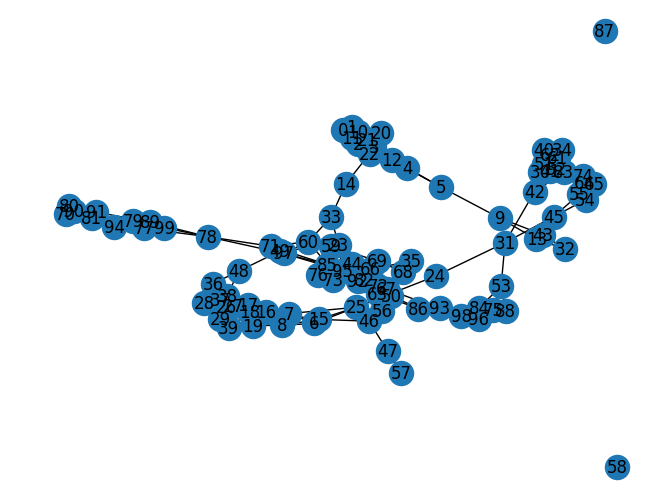

torch.Size([100, 3, 3, 3])


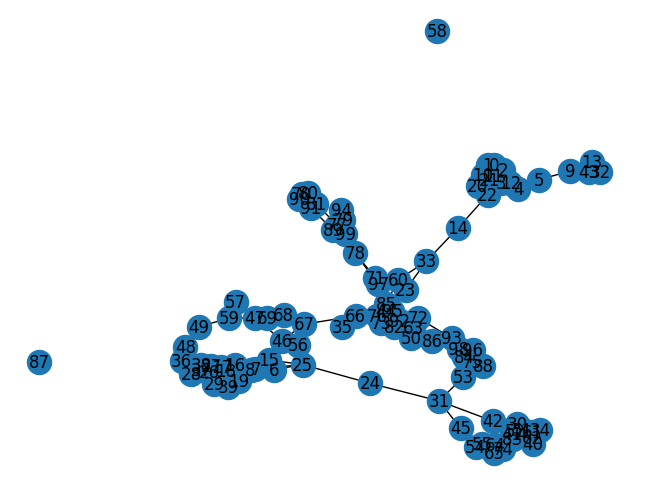

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

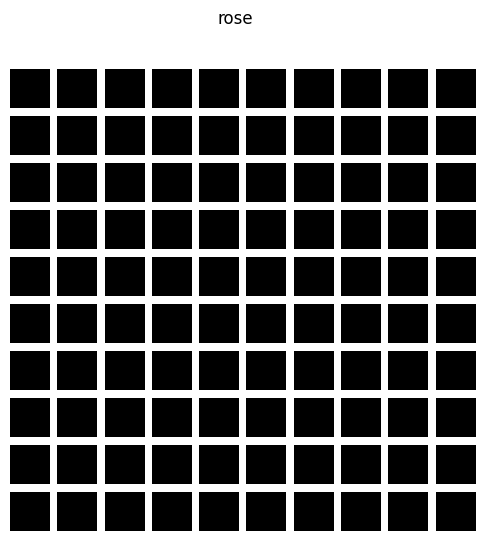

In [ ]:
(image_patches, edges_link, edges_attr), label = train_dataset[
    np.random.randint(0, len(train_dataset))
]
image_graph = Data(
    x=image_patches, edge_index=edges_link, edge_attr=edges_attr, y=label
)
from torch_geometric.utils import to_networkx
import networkx as nx

print(image_graph)
print(image_patches.shape, edges_link.shape, edges_attr.shape, label)

print(x.shape)
g = to_networkx(image_graph, to_undirected=True)
nx.draw(g, pos=nx.spring_layout(g), with_labels=True)
plt.show()
print(image_graph.x.shape)

nx.draw(
    to_networkx(image_graph.update(Data(x=x)), to_undirected=True),
    pos=nx.spring_layout(g),
    with_labels=True,
)
plt.show()

fig, axes = plt.subplots(10, 10, figsize=(6, 6))
for i in range(10):
    for j in range(10):
        axes[i, j].imshow(image_graph.x[i * 10 + j].permute(1, 2, 0).detach().numpy())
        axes[i, j].axis("off")
plt.suptitle(train_dataset.classes[label])
plt.show()

In [ ]:
print(image_graph.x.shape)

torch.Size([100, 3, 3, 3])
